# Menu <a class="anchor" id="menu"></a>

* [1. Les systèmes de recommandation](#intro)
* [2. Analyses exploratoires de `articles_metadata.csv`](#articles_metadata)
* [3. Analyses exploratoires de `clicks_hour_xxx.csv`](#clicks_hour)
* [4. Préparation du jeu de données de travail](#dataset)
    * [4.1 Fusion de `articles_metadata.csv` et `clicks_hour_xxx.csv`](#dataset_merge)
    * [4.2 Analyses exploratoires complémentaires](#dataset_eda)
    * [4.3 Nettoyage du jeu de données](#dataset_clean)
    * [4.4 Conception d'une feature de scoring](#dataset_score)
    * [4.5 Séparation du jeu de données en train-set & test-set](#dataset_split)

# Préparatifs 

In [1]:
import pickle
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm  #, uniform

import warnings
warnings.filterwarnings('ignore')

random_seed = 0
np.random.seed(random_seed)

In [2]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, log_scale=False, show_grid=False, x_label=None, y_label="Nombre d'articles"):

    fig = plt.figure(figsize=(15, 4))
    ax = sns.barplot(data=data_)
    if show_values:
        ax.bar_label(ax.containers[0])
    if log_scale:
        ax.set_yscale('log')
    if show_grid:
        plt.grid(visible=True, which='major', axis='y')
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

In [3]:
def explore_quantitative(data, col_name):
    dt = data[col_name]
    print(f'----- UNIVARIATE ANALYSIS for "{col_name}" -----\n',dt.describe(),'\n', sep='\n')

    fig = plt.figure(figsize=(15, 8))

    ax = plt.subplot(2, 2, 1)
    sns.boxplot(x=dt[dt.notnull()])
    plt.title(f"Boxplot for '{col_name}'")

    ax = plt.subplot(2, 2, 2)
    sns.kdeplot(dt, color='red')
    plt.title(f"Density plot for '{col_name}'")

    ax = plt.subplot(2, 2, 4)
    ax.set_title(f"QQplot for {col_name}")
    qqplot(data[data[col_name].notnull()][col_name], norm, fit=True, line="45", ax=ax)

    ###  Missing
    total_size = data.shape[0]
    total_size_nonull = data[col_name].notnull().sum()
    total_size_null = data[col_name].isnull().sum()
    percent_v = 100/total_size*total_size_null

    ax = plt.subplot(2, 2, 3)
    plt.pie(list([total_size_null, total_size_nonull]), labels=["", ""], autopct=lambda x: f"{x:.2f}%", shadow=False)
    plt.title(f"Distribution between rows with and without '{col_name}' values")
    plt.legend(["MISSING"], loc='lower center', bbox_to_anchor=(0, 0))

    fig.tight_layout()
    plt.show()

    print(f"'{col_name}' is missing {total_size_null} over {total_size} ({percent_v:.2f}%)")

In [4]:
def describe_with_extraQ(data, quantiles=[]):
    tmp = pd.DataFrame(data.describe())
    
    if len(quantiles) > 0:
        values, index = [], []
        
        for q in quantiles:
            values.append(data.quantile(q))
            index.append(f"{q*100:.1f}%")
        
        tmp = tmp.append(pd.DataFrame(values, columns=[tmp.columns[0]], index=index))
    
    return tmp

---
---
# 1. Les sytèmes de recommandation <a class="anchor" id="intro"></a> [⇪](#menu)

> Le but des systèmes de recommandation est de chercher des similarités entre utilisateurs ou éléments à recommander (livres, films, articles, vétements...) sur la base d'indicateurs permettant de définir de manière implicite ou explicite le degré de satisfaction lié à ces éléments. Une fois les éléments similaires identifiés, on peut recommander les X premiers ou tirer au hasard dans les X premiers etc.

<img src='medias/recommender_matrix.png' width=700>

> ### Dans les systèmes de recommandation, on a 3 approches généralement admises:
> 1. Collaborative Filtering
> 2. Content-based Filtering
> 3. Hybrid recommenders

<img src='medias/collaborative_vs_content_filtering.png' width=700>

> **Collaborative Filtering**<br>
> Le filtrage collaboratif est un ensemble de méthodes qui se basent uniquement sur *les interactions entre les utilisateurs et les éléments* qui ont été enregistrées, afin de produire de nouvelles recommandations.<br>
> <img src='medias/collaborative_filtering.png' width=700>
>
> 1. **Memory Based**
>    * **User-based or user-user collaborative filtering**<br>
>        Dans cette approche, la matrice d'évaluation *(rating matrix)* est utilisée pour trouver des **utilisateurs** similaires sur la base des évaluations qu'ils ont donné.<br>
>        L'un des algorithmes possible dans ce cas est le *Centered-KNN* *(KNNWithMeans)*
>    * **Item-based or item-item collaborative filtering**<br>
>        Dans cette approche, la matrice d'évaluation *(rating matrix)* est utilisée pour trouver des **articles** similaires sur la base des évaluations que leur attribuent les utilisateurs.<br>
>        L'un des algorithmes possible dans ce cas est le *Centered-KNN* *(KNNWithMeans)*<br><br>
> 2. **Model Based**
>    * **Matrix factorization**<br>
>        cette approche qui est la principale solution des model based, peut être considéré comme la décomposition d'une grande matrice en un produit de plus petites matrices. Le nombre de ces facteurs peut aller de un à des centaines, voire des milliers.<br>
>        Le nombre de facteurs latents est l'un des éléments qui doivent être optimisés pendant la formation du modèle. <br>
>        Le nombre de facteurs latents affecte les recommandations d'une manière telle que plus le nombre de facteurs est élevé, plus les recommandations sont personnalisées. Mais un trop grand nombre de facteurs peut conduire à un surajustement du modèle.
>
>        Il existe plusieurs algorithmes pouvant correspondre à cette approche:
>        * SVD / SVD++
>        * PCA / NMF
>        * Autoencoders (Neural Networks)

> **Content-based Filtering**<br>
> L'approche basée sur le contenu utilise des informations disponibles *(en plus des scores)* sur les utilisateurs et/ou les articles. Dans ce cas, on utilise donc les caractéristiques des articles pour recommander d'autres articles similaires à ceux que l'utilisateur aime, mais en s'appuyant également sur les actions précédentes, des commentaires, ou d'autres infos disponibles.<br>
> <img src='medias/content_filtering.png' width=700>

> **Hybrid recommenders**<br>
> Un système de recommandation hybride est un type particulier de système de recommandation qui peut être considéré comme la combinaison entre le *Collaborative Filtering* et le *Content-based Filtering*.



---
---
# 2. Analyses exploratoires de `articles_metadata.csv` <a class="anchor" id="articles_metadata"></a> [⇪](#menu)

> articles_metadata.csv - CSV file with metadata information about all (364047) published articles 

In [5]:
data_articles = pd.read_csv('data/news-portal-user-interactions-by-globocom/articles_metadata.csv')
display(data_articles.sample(5), data_articles.shape)

,article_id,category_id,created_at_ts,publisher_id,words_count
181932,181932,301,1507649455000,0,182
6245,6245,6,1417690563000,0,202
313837,313837,431,1515781621000,0,235
171070,171070,299,1459502786000,0,158
97803,97803,216,1437024112000,0,181


(364047, 5)

>#### Ce sont les informations permettant de décrire les articles *(nous n'avons accès ni aux titres ni aux textes des articles)*
> - `article_id` est le code d'identification unique de chaque article publié
> - `category_id` est le code d'identification unique de la catégorie à laquelle apprtient l'article
> - `created_at_ts` est le nombre de millisecondes écoulé entre le 01/01/1970 et la moment où l'article à été publié
> - `publisher_id` est le code d'identification unique de l'éditeur de l'article *(j'imagine que c'est prévu pour pouvoir s'ouvrir à d'autres éditeurs si ce n'est pas encore le cas)*
> - `words_count` est nombre de mots présents dans l'article
>
> Ce jeu de données est composé de **364K articles** décrites par **5 variables**

## 2.1 Vérifications de base <a class="anchor" id="articles_metadata_uni"></a> [⇪](#menu)

In [6]:
data_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


### Vérifions les valeurs manquantes

In [7]:
data_articles.isnull().sum()

article_id       0
category_id      0
created_at_ts    0
publisher_id     0
words_count      0
dtype: int64

### Vérifions les valeurs *(min, max, mean etc.)*

In [8]:
pd.set_option('float_format', '{:.0f}'.format)

In [9]:
data_articles.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
article_id,364047,182023,105091,0,91012,182023,273034,364046
category_id,364047,283,137,0,199,301,399,460
created_at_ts,364047,1474070237328,42930380229,1159355675000,1444924843500,1489422449000,1509890951000,1520943150000
publisher_id,364047,0,0,0,0,0,0,0
words_count,364047,191,60,0,159,186,218,6690


In [10]:
# pd.reset_option('float_format')
pd.set_option('float_format', '{:.2f}'.format)

>#### Il se pourrait que l'on ait quelques valeurs aberrantes.
> - ⚠️ `created_at_ts` : les dates vont du **27/09/2006 11:14:35 GMT au 13/03/2018 12:12:30 GMT**, alors que le jeu de données est décrit comme allant du  **01/10/2017 au 16/10/2017**. Donc même si l'on considère que les articles peuvent être plus vieux que les click utilisateurs, il est peu probable qu'un article de 2018 trouve légitimment sa place dans notre jeu de données.
>
> - ⚠️ `words_counts` : la taille des articles varie de **0 à 6690**... Un article de 0 mots n'a aucun sens, et 6690 est très au dessus de la moyenne de 186 mots ou même du 3ème quartile de 218 mots.
>

>#### En revanches les autres colonnes ne semblent pas présenter de valeurs aberrantes
> - `article_id` : chaque article possède bien un ID unique
> - `category_id` : on constate qu'il y a 461 catégories d'articles, mais il n'y a pas de raison de croire que c'est un problème.
> - `publisher_id` : on constate qu'il y a 1 seul éditeur, mais c'est tout à fait attendu (on peut imaginer que seul l'équipe de Globo.com peut publier sur Globo.com)

### Doublons

#### Regardons si il y des articles en double sur la base de la colonnes `article_id`

In [11]:
data_articles.duplicated(subset=['article_id']).sum()

0

### Regardons plus en détails la colonne `created_at_ts`

----- UNIVARIATE ANALYSIS for "created_at_ts" -----

count          364047.00
mean    1474070237328.42
std       42930380228.81
min     1159355675000.00
25%     1444924843500.00
50%     1489422449000.00
75%     1509890951000.00
max     1520943150000.00
Name: created_at_ts, dtype: float64




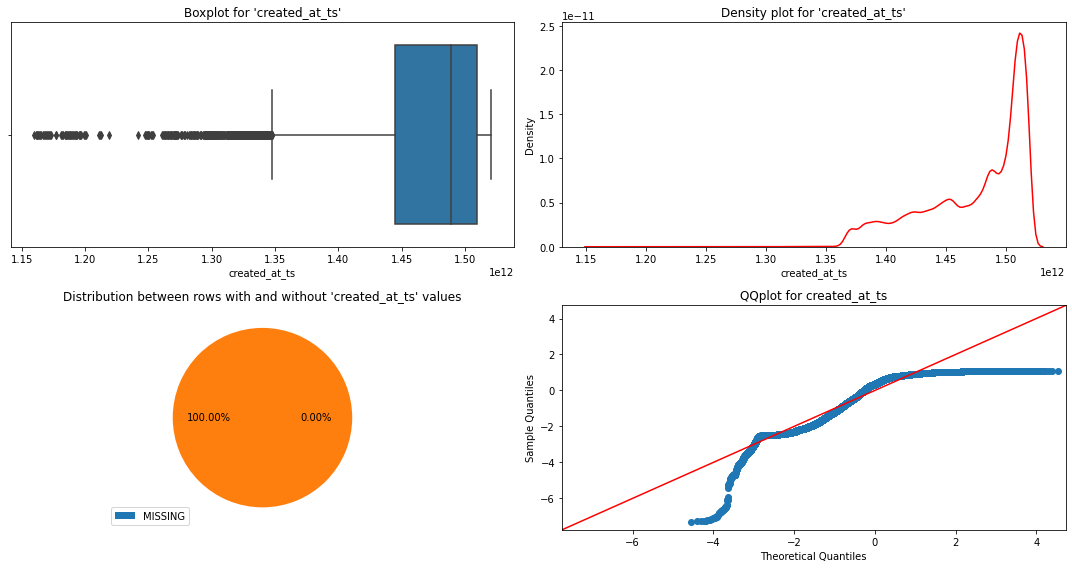

'created_at_ts' is missing 0 over 364047 (0.00%)


In [12]:
explore_quantitative(data_articles, 'created_at_ts')

### Regardons plus en détails la colonne `words_count`

----- UNIVARIATE ANALYSIS for "words_count" -----

count   364047.00
mean       190.90
std         59.50
min          0.00
25%        159.00
50%        186.00
75%        218.00
max       6690.00
Name: words_count, dtype: float64




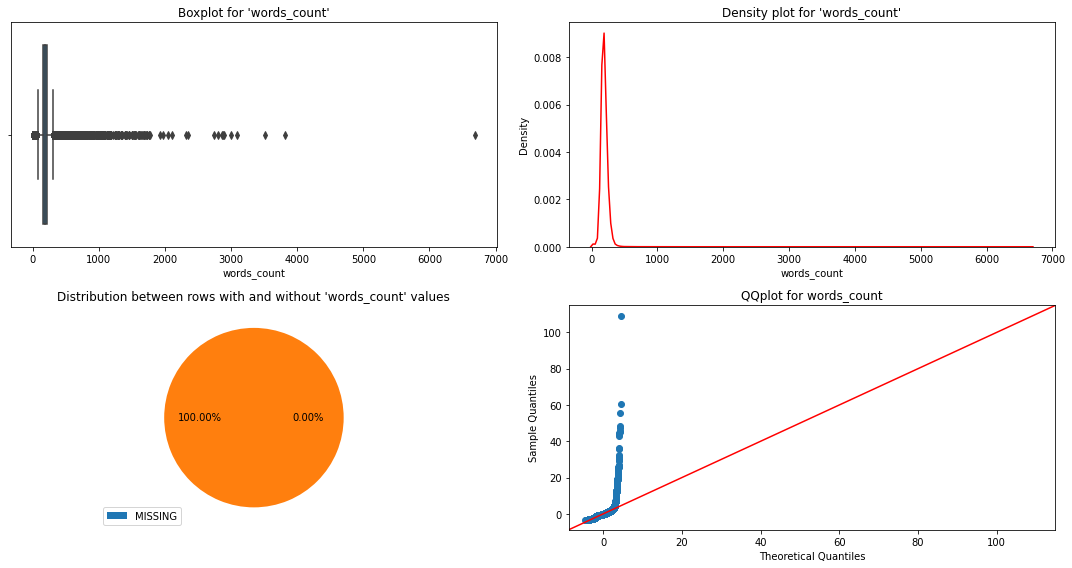

'words_count' is missing 0 over 364047 (0.00%)


In [13]:
explore_quantitative(data_articles, 'words_count')

## 2.2 Analyses multivariées <a class="anchor" id="articles_metadata_multi"></a> [⇪](#menu)

### Regardons la repartition des articles dans le temps

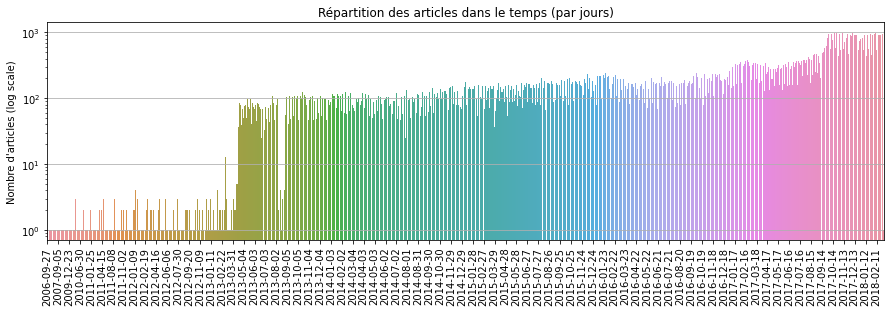

In [14]:
selection = data_articles[['article_id', 'created_at_ts']].copy()
selection['short_date'] = selection['created_at_ts'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m-%d"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count']).T

plot_bars(
    selection, 
    "Répartition des articles dans le temps (par jours)", 
    y_label="Nombre d'articles (log scale)",
    labels_modulo=30, show_values=False, log_scale=True, show_grid=True,
)

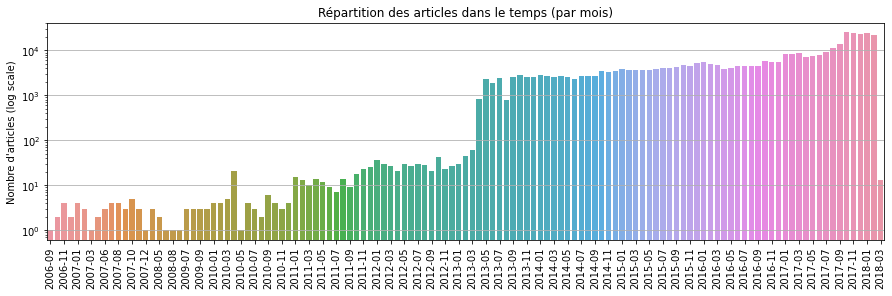

In [15]:
selection = data_articles[['article_id', 'created_at_ts']].copy()
selection['short_date'] = selection['created_at_ts'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count']).T

plot_bars(
    selection, 
    "Répartition des articles dans le temps (par mois)", 
    y_label="Nombre d'articles (log scale)",
    labels_modulo=2, show_values=False, log_scale=True, show_grid=True,
)

---
>#### `TODO`  done ✅ | todo ❌ |
> - ❌ Supprimer les articles dont les valeurs sont plus récentes que le plus récent des clicks ?<br>(où vont ils être naturellement éliminés losque l'on ne va retenir que les articles aillant reçu un minimum de clicks ?)
> - ❌ Supprimer la colonne `publisher_id` qui ne présente qu'une unique valeur.
> - ❌ Supprimer les articles qui ne sont pas utilisés dans le jeu de données clicks_hour.zip

---
---
# 3. Analyses exploratoires de `clicks_hour_XXX.csv` <a class="anchor" id="clicks_hour"></a> [⇪](#menu)
> clicks.zip - Folder with CSV files (one per hour), containing user sessions interactions in the news portal.

## 3.1 Concatenate all clicks CSV files <a class="anchor" id="clicks_hour_concat"></a> [⇪](#menu)

clicks.zip - Folder with CSV files (one per hour), containing user sessions interactions in the news portal.

In [16]:
datalist = []
for i in range(0, 385):
    data_tmp = pd.read_csv(f'data/news-portal-user-interactions-by-globocom/clicks/clicks_hour_{i:03}.csv')
    data_tmp['hour'] =  i
    datalist.append(data_tmp)

data_clicks = pd.concat(datalist)
display(data_clicks.head(), data_clicks.shape)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,0
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,0
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,0
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,0
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,0


(2988181, 13)

>#### Ce sont les informations permettant de décrire les interactions utilisateur sur le site Globo.com
> - `user_id` est le code d'identification unique de chaque utilisateur du site
> - `session_id` est le code d'identification unique de chaque session utilisateur *(chaque session peut avoir plusieurs interactions, donc être présente plusieurs fois)*
> - `session_start` est le nombre de millisecondes écoulé entre le 01/01/1970 et la moment où l'utilisateur à commencé sa session sur le site
> - `session_size` est le nombre d'interactions enregistrées dans la session associée
> - `click_article_d` est le code d'identification unique de l'article auquel mène le click
> - `click_timestamp` est le nombre de millisecondes écoulé entre le 01/01/1970 et la moment où l'utilisateur à clické pour visiter l'article associé
> - `click_environment` est ❓
> - `click_deviceGroup` est ❓
> - `click_os` est *probablement un code d'identification lié aux différents operating systems et leurs déclinaisons* ❓
> - `click_country` est le code d'identification unique de chaque pays (le 1 semble être le Brézil)
> - `click_region` est le code d'identification unique de chaue région du pays associé
> - `click_referrer` est *probablement le code d'identification du site d'où vient le click* ❓
> - `hour` est l'identifiant du CSV d'origine contenu dans clicks.zip *(clicks_hour_{HOUR}.csv)*
>
> Ce jeu de données est composé de **299K interactions** décrites par **13 variables**

## 3.2 Vérifications de base <a class="anchor" id="clicks_hour_uni"></a> [⇪](#menu)

In [17]:
data_clicks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2988181 entries, 0 to 2568
Data columns (total 13 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
 12  hour                 int64 
dtypes: int64(1), object(12)
memory usage: 319.2+ MB


### Ajustons les types de colonnes pour faciliter le travail d'analyse

In [18]:
#for col in ['user_id', 'session_id', 'click_article_id', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']:
for col in ['click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']:
    data_clicks[col] = data_clicks[col].astype('category')
    
for col in ['user_id', 'session_id', 'click_article_id', 'session_start', 'click_timestamp', 'session_size']:
    data_clicks[col] = data_clicks[col].astype('int64')

In [19]:
data_clicks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2988181 entries, 0 to 2568
Data columns (total 13 columns):
 #   Column               Dtype   
---  ------               -----   
 0   user_id              int64   
 1   session_id           int64   
 2   session_start        int64   
 3   session_size         int64   
 4   click_article_id     int64   
 5   click_timestamp      int64   
 6   click_environment    category
 7   click_deviceGroup    category
 8   click_os             category
 9   click_country        category
 10  click_region         category
 11  click_referrer_type  category
 12  hour                 int64   
dtypes: category(6), int64(7)
memory usage: 199.5 MB


### Vérifions les valeurs manquantes

In [20]:
data_clicks.isnull().sum()

user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
hour                   0
dtype: int64

### Vérifions les valeurs *(min, max, mean etc.)*

In [21]:
pd.set_option('float_format', '{:.0f}'.format)

In [22]:
data_clicks.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
user_id,2988181,107948,83648,0,40341,86229,163261,322896
session_id,2988181,1507472228344485,385524460231,1506825423271737,1507124152253606,1507493340299445,1507749414106993,1508211379189330
session_start,2988181,1507472228013,385524460,1506825423000,1507124152000,1507493340000,1507749414000,1508211379000
session_size,2988181,4,4,2,2,3,4,124
click_article_id,2988181,194923,90768,3,124228,202381,277067,364046
click_timestamp,2988181,1507474265606,385850960,1506826800026,1507126852854,1507494930481,1507751004601,1510603454886
hour,2988181,179,107,0,82,185,256,384


In [23]:
data_clicks.describe(exclude='number').T

,count,unique,top,freq
click_environment,2988181,3,4,2904478
click_deviceGroup,2988181,5,1,1823162
click_os,2988181,8,17,1738138
click_country,2988181,11,1,2852406
click_region,2988181,28,25,804985
click_referrer_type,2988181,7,2,1602601


In [24]:
# pd.reset_option('float_format')
pd.set_option('float_format', '{:.2f}'.format)

>#### Il se pourrait que l'on ait quelques valeurs aberrantes.
> * `session_start`: les dates vont du **01/10/2017 02:37:03 GMT au 17/10/2017 03:36:19 GMT**.
> * `click_timestamp`: les dates vont du **01/10/2017 03:00:00 GMT au 13/11/2017 20:04:14 GMT**.
> <br>⚠️ On a donc une session qui a duré au minimum 27 jours *(17/10 -> 13/11)*.
> * `user_id` : certains utilisateurs semblent avoir un nombre de session très au dessus de la moyenne. Est-ce un problème ❓
> - `session_size` : la taille des sessions varie de **2 à 124**... 124 semble très au dessus du troisième quartile qui est à 4.

>#### En revanches les autres colonnes ne semblent pas présenter de valeurs aberrantes
> - `session_id` : la session la plus fréquente (124) correspond au nombre maximum de session_size (124) et le reste semble cohérent.
> - `click_article_id` : seuls **46033 des 364047 articles sont utilisés**, mais ça ne pose pas de problème.
> - `click_environment` : on a visiblement 3 environnements (web/ios/android ?) pris en compte. Rien d'anormal.
> - `click_deviceGroup`, `click_os`, `click_country`, `click_region`, `click_referrer_type` ont toutes des valeurs qui semblent raisonnables même si l'on considère que l'on ne sait pas toujours exactement ce qu'elles représentent.


### Regardons plus en détails la colonne `session_start`

short_date,2017-10-01,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-07,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-17
count,75205.00,290443.00,282762.00,210182.00,190898.00,207027.00,147253.00,104685.00,242356.00,282524.00,242362.00,123316.00,183344.00,99641.00,84054.00,192185.00,29944.00
count_percent,2.52,9.72,9.46,7.03,6.39,6.93,4.93,3.50,8.11,9.45,8.11,4.13,6.14,3.33,2.81,6.43,1.00


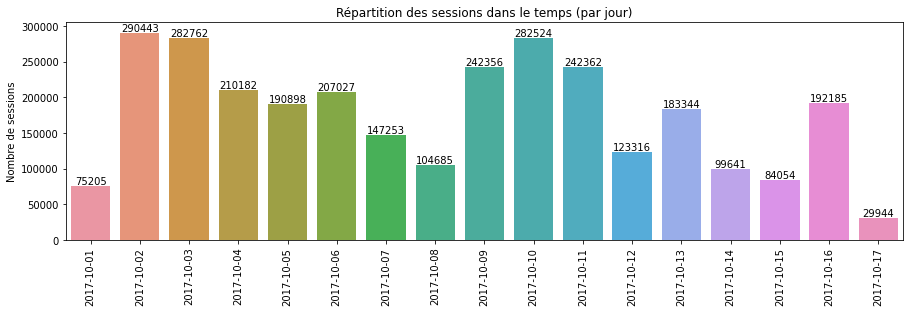

In [25]:
selection = data_clicks[['session_id', 'session_start']].copy()
selection['short_date'] = selection['session_start'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m-%d"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count'])

selection["count_percent"] = 100 / selection['count'].sum() * selection
display(selection.T)
selection = selection[['count']].T

plot_bars(
    selection, 
    "Répartition des sessions dans le temps (par jour)", 
     y_label='Nombre de sessions',
    labels_modulo=1, show_values=True,
)

### Regardons plus en détails la colonne `click_timestamp`

short_date,2017-10-01,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-07,2017-10-08,2017-10-09,2017-10-10,...,2017-10-26,2017-10-27,2017-10-28,2017-10-30,2017-10-31,2017-11-01,2017-11-03,2017-11-04,2017-11-07,2017-11-13
count,72106.00,286952.00,285219.00,210454.00,190165.00,207840.00,147946.00,104423.00,240519.00,283115.00,...,12.00,8.00,2.00,12.00,4.00,6.00,2.00,2.00,2.00,2.00
count_percent,2.41,9.60,9.54,7.04,6.36,6.96,4.95,3.49,8.05,9.47,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


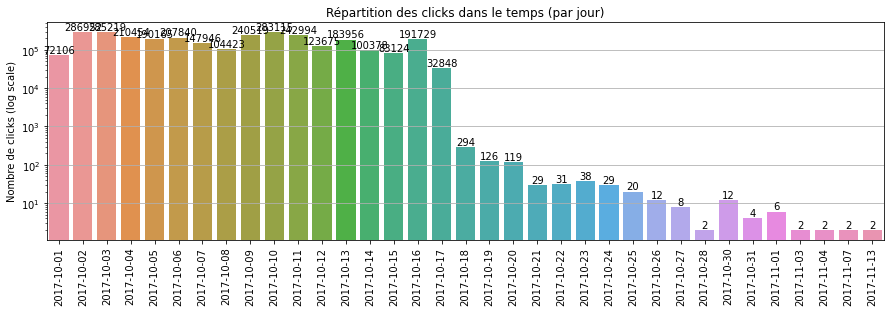

In [26]:
selection = data_clicks[['session_id', 'click_timestamp']].copy()
selection['short_date'] = selection['click_timestamp'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m-%d"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count'])

selection["count_percent"] = 100 / selection['count'].sum() * selection
display(selection.T)
selection = selection[['count']].T

plot_bars(
    selection, 
    "Répartition des clicks dans le temps (par jour)", 
    y_label='Nombre de clicks (log scale)',
    labels_modulo=1, show_values=True, log_scale=True, show_grid=True, 
)

> #### ⚠️ On note que les dates de clicks s'étendent bien au dela des dates de début de session *(on des clicks presque 1 mois après le dernier début de session enregistré)*

## 3.3 Analyses multivariées <a class="anchor" id="clicks_hour_multi"></a> [⇪](#menu)

### Regardons le nombre d'articles lus par utilisateurs

num_articles,2,3,4,5,6,7,8,9,10,11,...,501,502,513,529,722,746,783,900,939,1232
num_users,101428.00,22660.00,38432.00,18070.00,20370.00,13358.00,12780.00,9701.00,8807.00,7143.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
num_users_percent,31.41,7.02,11.90,5.60,6.31,4.14,3.96,3.00,2.73,2.21,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


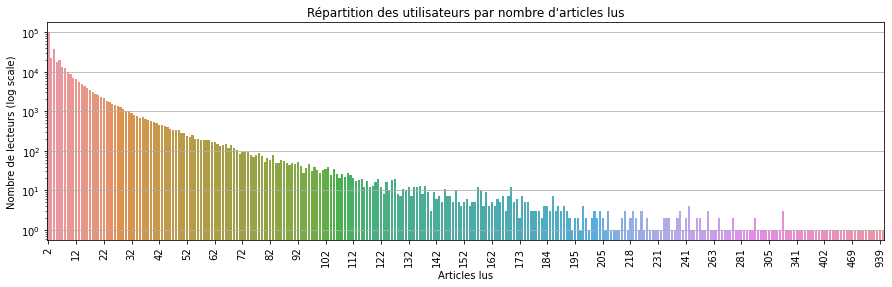

In [27]:
selection = data_clicks[['user_id','click_article_id']].copy()
selection = pd.DataFrame(selection.groupby('user_id').size(), columns=['num_articles'])
selection = pd.DataFrame(selection.groupby('num_articles').size(), columns=['num_users'])

selection["num_users_percent"] = 100 / data_clicks['user_id'].nunique() * selection
display(selection.T)
selection = selection[['num_users']].T

plot_bars(
    selection, 
    "Répartition des utilisateurs par nombre d'articles lus", 
    x_label="Articles lus", y_label="Nombre de lecteurs (log scale)",
    labels_modulo=10, show_values=False, log_scale=True, show_grid=True, 
)

Regardons plus en détail les 25 premiers

num_articles,2,3,4,5,6,7,8,9,10,11,...,17,18,19,20,21,22,23,24,25,26
num_users,101428.00,22660.00,38432.00,18070.00,20370.00,13358.00,12780.00,9701.00,8807.00,7143.00,...,3458.00,3040.00,2755.00,2557.00,2281.00,2120.00,1864.00,1725.00,1554.00,1487.00
num_users_percent,31.41,7.02,11.90,5.60,6.31,4.14,3.96,3.00,2.73,2.21,...,1.07,0.94,0.85,0.79,0.71,0.66,0.58,0.53,0.48,0.46


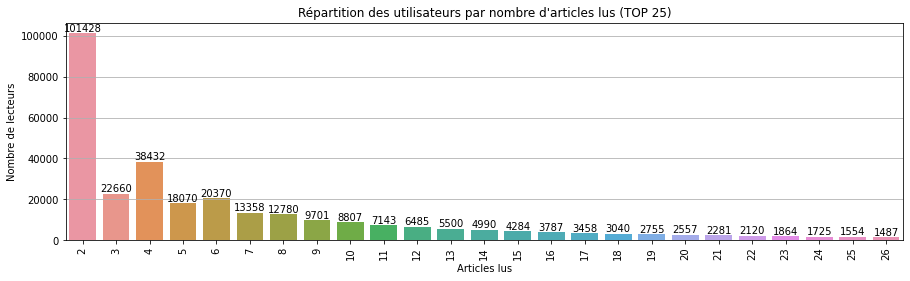

In [28]:
selection = data_clicks[['user_id','click_article_id']].copy()
selection = pd.DataFrame(selection.groupby('user_id').size(), columns=['num_articles'])
selection = pd.DataFrame(selection.groupby('num_articles').size(), columns=['num_users'])[:25]

selection["num_users_percent"] = 100 / data_clicks['user_id'].nunique() * selection
display(selection.T)
selection = selection[['num_users']].T

plot_bars(
    selection, 
    "Répartition des utilisateurs par nombre d'articles lus (TOP 25)", 
    x_label="Articles lus", y_label="Nombre de lecteurs",
    labels_modulo=1, show_values=True, log_scale=False, show_grid=True, 
)

In [29]:
selection = data_clicks[['user_id','click_article_id']].copy()

min_reads = 5
selection = pd.DataFrame(selection.groupby('user_id').size(), columns=['num_articles'])
selection = pd.DataFrame(selection.groupby('num_articles').size(), columns=['num_users'])
selection = selection[ selection.index >= min_reads]
selection["num_users_percent"] = 100 / data_clicks['user_id'].nunique() * selection

print(f"{selection['num_users'].sum()} utilisateurs ({selection['num_users_percent'].sum():.2f}%) ont lus plus de {min_reads} articles")

160377 utilisateurs (49.67%) ont lus plus de 5 articles


> * On peut voir que tous les utilisateurs ont lus au moins 2 articles
> * On peut également noter que plus de **31% des utilisateurs n'ont lu que 2 articles**... ils ne sont peut être pas pertinents pour faire de la recommandation.
> * De même en pourcentage cumulé, plus de **50% des utilisateurs ont lus 4 articles ou moins**...
>>
> * En pourcentage cumulé, environ **50% des utilisateurs ont lus 5 articles ou plus**...
> * En pourcentage cumulé, environ **27% des utilisateurs ont lus 10 articles ou plus**...
> * En pourcentage cumulé, environ **2% des utilisateurs ont lus 50 articles ou plus**...
> * En pourcentage cumulé, environ **0.35% des utilisateurs ont lus 100 articles ou plus**...

### Regardons le nombre de lecteurs par article

total_reads,1,2,3,4,5,6,7,8,9,10,...,19526,20303,21062,21577,21855,23122,23499,23851,28943,37213
num_articles,24811.00,4682.00,2129.00,1315.00,990.00,746.00,621.00,504.00,476.00,384.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
num_articles_percent,53.90,10.17,4.62,2.86,2.15,1.62,1.35,1.09,1.03,0.83,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


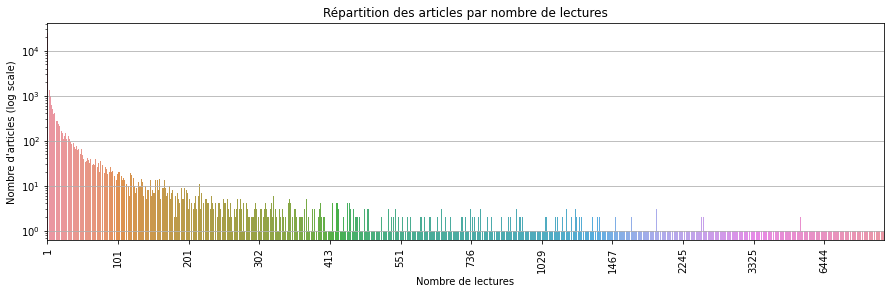

In [30]:
selection = data_clicks[['user_id','click_article_id']].copy()

selection = pd.DataFrame(selection.groupby('click_article_id').size(), columns=['total_reads']) # ici on a le nombre de lectures pour chaque article
selection = pd.DataFrame(selection.groupby('total_reads').size(), columns=['num_articles']) # ici on a le nombre d'article regroupés par nombre de lectures

selection["num_articles_percent"] = 100 / data_clicks['click_article_id'].nunique() * selection
display(selection.T)
selection = selection[['num_articles']].T

plot_bars(
    selection, 
    "Répartition des articles par nombre de lectures", 
    x_label="Nombre de lectures", y_label="Nombre d'articles (log scale)",
    labels_modulo=100, show_values=False, log_scale=True, show_grid=True, 
)

Regardons plus en détail les 25 premiers

total_reads,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
num_articles,24811.00,4682.00,2129.00,1315.00,990.00,746.00,621.00,504.00,476.00,384.00,...,247.00,232.00,209.00,193.00,175.00,165.00,149.00,160.00,106.00,126.00
num_articles_percent,53.90,10.17,4.62,2.86,2.15,1.62,1.35,1.09,1.03,0.83,...,0.54,0.50,0.45,0.42,0.38,0.36,0.32,0.35,0.23,0.27


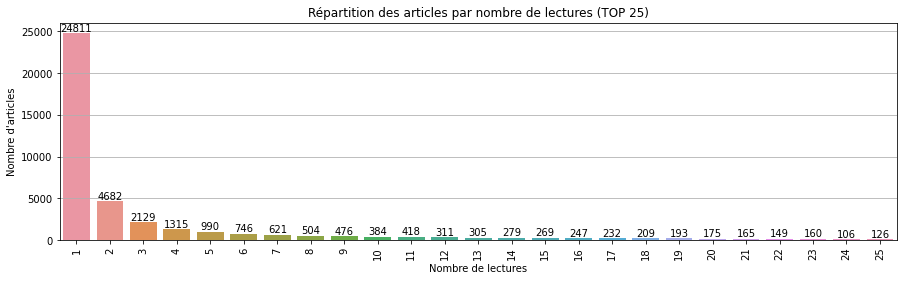

In [31]:
selection = data_clicks[['user_id','click_article_id']].copy()

selection = pd.DataFrame(selection.groupby('click_article_id').size(), columns=['total_reads']) # ici on a le nombre de lectures pour chaque article
selection = pd.DataFrame(selection.groupby('total_reads').size(), columns=['num_articles'])[:25] # ici on a le nombre d'article regroupés par nombre de lectures

selection["num_articles_percent"] = 100 / data_clicks['click_article_id'].nunique() * selection
display(selection.T)
selection = selection[['num_articles']].T

plot_bars(
    selection, 
    "Répartition des articles par nombre de lectures (TOP 25)", 
    x_label="Nombre de lectures", y_label="Nombre d'articles",
    labels_modulo=1, show_values=True, log_scale=False, show_grid=True, 
)

In [32]:
selection = data_clicks[['user_id','click_article_id']].copy()

min_reads = 5
selection = pd.DataFrame(selection.groupby('click_article_id').size(), columns=['total_reads']) # ici on a le nombre de lectures pour chaque article
selection = pd.DataFrame(selection.groupby('total_reads').size(), columns=['num_articles']) # ici on a le nombre d'article regroupés par nombre de lectures
selection = selection[ selection.index >= min_reads]
selection["num_articles_percent"] = 100 / data_clicks['click_article_id'].nunique() * selection

print(f"{selection['num_articles'].sum()} articles ({selection['num_articles_percent'].sum():.2f}%) ont été lus au moins {min_reads} fois")

13096 articles (28.45%) ont été lus au moins 5 fois


In [33]:
selection = data_clicks[['user_id','click_article_id']].copy()
selection = pd.DataFrame(selection.groupby('click_article_id').size(), columns=['total_reads']) # ici on a le nombre de lectures pour chaque article
display(selection.describe().T)
print(f"Le quartile 0.99 se situe à {int(selection.quantile(0.99))} articles lus")

,count,mean,std,min,25%,50%,75%,max
total_reads,46033.00,64.91,629.32,1.00,1.00,1.00,6.00,37213.00


Le quartile 0.99 se situe à 1203 articles lus


> * Environ **54% des articles ont été lus une seule fois**...
> * En pourcentage cumulé, environ **75% des articles ont été lus 6 fois ou moins**.
>>
> * En pourcentage cumulé, environ **28% des articles ont été lus 5 fois ou plus**.
> * En pourcentage cumulé, environ **21% des articles ont été lus 10 fois ou plus**.
> * En pourcentage cumulé, environ **9% des articles ont été lus 50 fois ou plus**.
> * En pourcentage cumulé, environ **5% des articles ont été lus 100 fois ou plus**.
> * En pourcentage cumulé, environ **1% des articles ont été lus 1000 fois ou plus**.

### Regardons la durée des sessions

#### Temps entre l'ouverture de la session et le premier click

In [34]:
selection = data_clicks.copy()
selection['time_since_session_start'] = selection['click_timestamp'] - selection['session_start']
#display(selection[selection.session_id == 1506825426267738])

first_click = selection.groupby('session_id')['time_since_session_start'].min()
print(f'Temps pour le premier click: mini={(first_click.min()/1000):.0f} secondes | moyen={(first_click.mean()/1000):.0f} secondes | maxi={(first_click.max()/1000):.0f} secondes')

Temps pour le premier click: mini=0 secondes | moyen=787 secondes | maxi=1030097 secondes


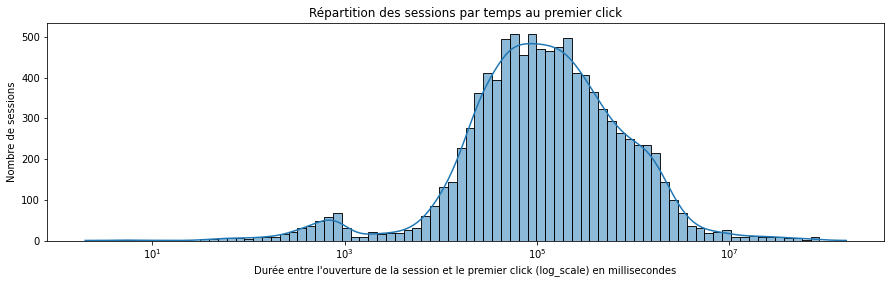

In [35]:
fig = plt.figure(figsize=(15, 4))
ax = sns.histplot(data=pd.DataFrame(first_click[:10000]), x="time_since_session_start", bins='auto', kde=True, log_scale=True )
plt.title("Répartition des sessions par temps au premier click")
plt.ylabel("Nombre de sessions")
plt.xlabel("Durée entre l'ouverture de la session et le premier click (log_scale) en millisecondes")
plt.show()

#### Temps entre l'ouverture de la session et le dernier click

In [36]:
last_click = selection.groupby('session_id')['time_since_session_start'].max()
print(f'Temps pour le dernier click: mini={(last_click.min()/1000):.0f} secondes | moyen={(last_click.mean()/1000):.0f} secondes | maxi={(last_click.max()/1000):.0f} secondes')

Temps pour le dernier click: mini=30 secondes | moyen=1624 secondes | maxi=2420268 secondes


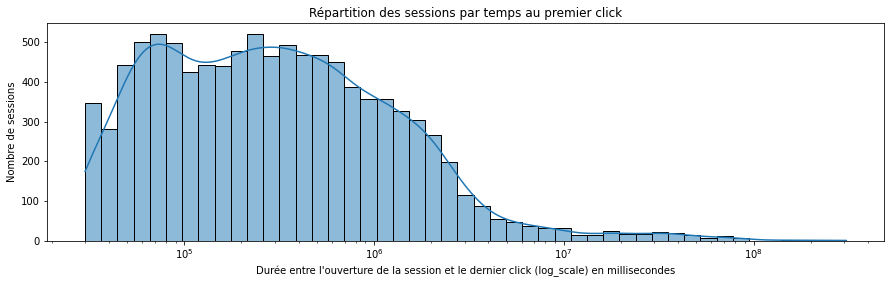

In [37]:
fig = plt.figure(figsize=(15, 4))
ax = sns.histplot(data=pd.DataFrame(last_click[:10000]), x="time_since_session_start", bins='auto', kde=True, log_scale=True )
plt.title("Répartition des sessions par temps au premier click")
plt.ylabel("Nombre de sessions")
plt.xlabel("Durée entre l'ouverture de la session et le dernier click (log_scale) en millisecondes")
plt.show()

> La plupart des sessions ont un dernier click autour de 30 min.

#### Temps entre 2 sessions *(donc session_size-1)*

In [38]:
selection = data_clicks[['session_id', 'session_start', 'session_size', 'click_timestamp']].copy()
selection = selection.sort_values('click_timestamp')

selection2 = selection.groupby('session_id').diff(periods=-1)
selection2.rename(columns={'click_timestamp':'duration'}, inplace=True)
selection2 = -selection2['duration']/1000

selection = pd.concat([selection, selection2], axis=1)
selection.head(3)

,session_id,session_start,session_size,click_timestamp,duration
147,1506826329267796,1506826329000,2,1506826800026,30.00
208,1506826486139816,1506826486000,2,1506826801702,30.00
399,1506826793323891,1506826793000,2,1506826804207,30.00


In [39]:
selection[selection.session_id == 1507932701183006]

,session_id,session_start,session_size,click_timestamp,duration
3275,1507932701183006,1507932701000,10,1508714220422,83334.67
3276,1507932701183006,1507932701000,10,1508797555093,601206.26
3277,1507932701183006,1507932701000,10,1509398761350,24.35
3278,1507932701183006,1507932701000,10,1509398785698,28.59
3279,1507932701183006,1507932701000,10,1509398814292,233.89
3280,1507932701183006,1507932701000,10,1509399048186,89574.18
3281,1507932701183006,1507932701000,10,1509488622369,62347.90
3282,1507932701183006,1507932701000,10,1509550970271,542912.59
3283,1507932701183006,1507932701000,10,1510093882860,30.00
3284,1507932701183006,1507932701000,10,1510093912860,NaN


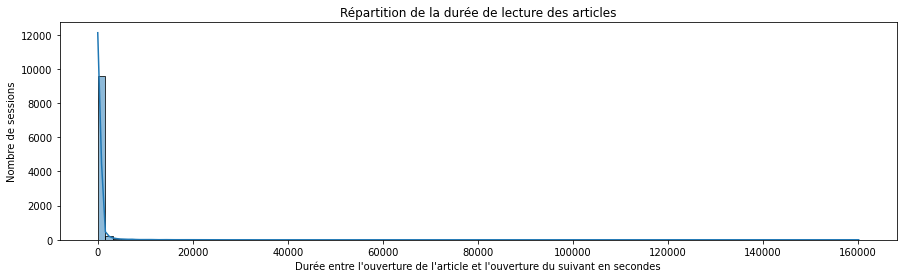

In [40]:
fig = plt.figure(figsize=(15, 4))
ax = sns.histplot(data=selection['duration'].dropna().sample(10000, random_state=random_seed), bins=100, kde=True, log_scale=False )
plt.title("Répartition de la durée de lecture des articles")
plt.ylabel("Nombre de sessions")
plt.xlabel("Durée entre l'ouverture de l'article et l'ouverture du suivant en secondes")
# plt.ylim([0,2000])
plt.show()

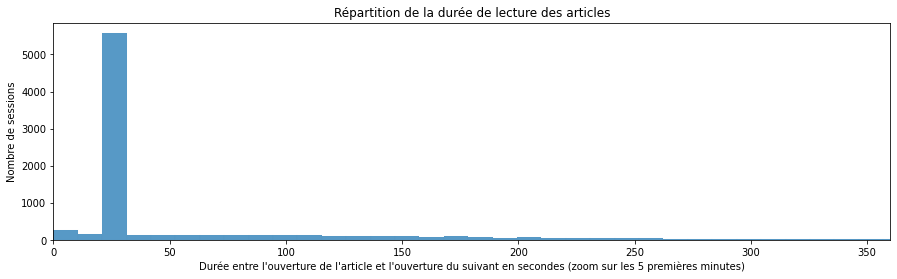

In [41]:
fig = plt.figure(figsize=(15, 4))
ax = sns.histplot(data=selection['duration'].dropna().sample(10000, random_state=random_seed), bins='auto', kde=False, log_scale=False )
plt.title("Répartition de la durée de lecture des articles")
plt.ylabel("Nombre de sessions")
plt.xlabel("Durée entre l'ouverture de l'article et l'ouverture du suivant en secondes (zoom sur les 5 premières minutes)")
plt.xlim([0,360])
plt.show()

In [42]:
selection.duration.describe()

count   1939587.00
mean        452.47
std        5313.35
min          -0.00
25%          30.00
50%          30.00
75%         143.65
max     1212149.26
Name: duration, dtype: float64

In [43]:
selection.shape, selection.duration.quantile(0.99)

((2988181, 5), 6596.008499999956)

In [44]:
selection[selection.duration > selection.duration.quantile(0.99)].shape

(19396, 5)

>#### On constate qu'il est possible d'obtenir un temps de consultation pour la plupart des articles (tous sauf le dernier de la session).
> Ces temps sont évidemment approximatifs, mais divisé par le nombre de mots contenus dans les articles ils pourraient faire un score implicite intéressant.
>>
> * Le temps moyen de consultation est de 30 secondes
> * Le temps minimum est de 0 secondes *(il faudrait donc faire du nettoyage - en supprimant tout ce qui est plus petit que X secondes )*
> * Le temps maximum est de 1212149 secondes, soit 14 jours *(il faudrait donc faire du nettoyage - sur la base de quartile(0.99) par exemple )*

---
>#### `TODO`  done ✅ | todo ❌ |
> - ❌ Supprimer les sessions dont la taille est atypique *(on supprime ce qui dépasse quartile(0.99))* ❓
>>
> - ✅ Supprimer les sessions dont les utilisateurs ont lus trop peu d'articles *(moins de 10 ? moins que le nombre d'articles à recommander ?)*<br>*(action: supprimé en section 4.2.2)*
> - ❌ Supprimer les sessions dont les utilisateurs ont lus trop d'articles *(on supprime ce qui dépasse quartile(0.99))* ❓
>>
> - ✅ Supprimer les sessions dont les articles n'ont été lus qu'une seule fois *(53.9%)*<br>*(action: supprimé en section 4.2.1)*
> - ❌ Supprimer les sessions dont les articles ont été lus trop souvent *(on supprime ce qui dépasse quartile(0.99) soit 1200 environ)* ❓
>>
> **Si l'on utiliser les temps de consultation pour un score implicite**, il faut:
> - ❌ Supprimer les articles sans durée (le dernier)
> - ❌ Supprimer les articles avec une durée de consultation trop courte (-4 ou 5 secondes)
> - ❌ Supprimer les articles avec une durée de consultation trop longue (utilisons le quartile 0.99)

---
---
# 4. Préparation du jeu de données de travail <a class="anchor" id="dataset"></a> [⇪](#menu)

## 4.1 Fusion de `articles_metadata.csv` et `clicks_hour_xxx.csv` <a class="anchor" id="dataset_merge"></a> [⇪](#menu)

In [45]:
data_merge = pd.merge(data_clicks, data_articles, how='left', left_on='click_article_id', right_on='article_id')
display(data_merge.head(), data_merge.shape)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,0,157541,281,1506800518000,0,280
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,0,68866,136,1506816482000,0,226
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,0,235840,375,1506807839000,0,159
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,0,96663,209,1506788025000,0,206
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,0,119592,247,1506784316000,0,239


(2988181, 18)

### Vérifions la taille de la jointure

In [46]:
print("data_article.shape:", data_articles.shape, "\ndata_clicks.shape:", data_clicks.shape, "\ndata_merge.shape:", data_merge.shape)

data_article.shape: (364047, 5) 
data_clicks.shape: (2988181, 13) 
data_merge.shape: (2988181, 18)


> On a donc bien un dataset_merge qui à le même nombre de lignes que data_clicks et un nombre de colonnes égale à l'ensemble des colonnes des deux datasets

### Vérifions le contenu de la jointure

In [47]:
index = 0

In [48]:
pd.DataFrame(data_merge.iloc[index]).T

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,0,157541,281,1506800518000,0,280


In [49]:
pd.DataFrame(data_clicks.iloc[index]).T

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,0


In [50]:
data_articles[ data_articles.article_id == data_clicks.iloc[index].click_article_id ]

,article_id,category_id,created_at_ts,publisher_id,words_count
157541,157541,281,1506800518000,0,280


> Visiblement la jointure s'est bien passée, et on a les bons articles associés aux sessions

In [51]:
data_merge.drop(['click_article_id'], axis=1, inplace=True)
data_merge.head(1)

,user_id,session_id,session_start,session_size,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,1506825423271737,1506825423000,2,1506826828020,4,3,20,1,20,2,0,157541,281,1506800518000,0,280


## 4.2 Nettoyage du jeu de données <a class="anchor" id="dataset_clean"></a> [⇪](#menu)

In [52]:
data_clean = data_merge.copy()

### 4.2.1 Supprimons les sessions liées aux articles lus une seule fois *(moins de 2 lectures)*

In [53]:
min_clicks_articles = 5

In [54]:
count_articles_clicks = data_clean.groupby(['article_id']).size()
count_articles_clicks.head(5)

article_id
3     1
27    1
69    1
81    2
84    1
dtype: int64

In [55]:
size_before = data_clean.shape

select_ids = [k for k,v in count_articles_clicks.iteritems() if v >= min_clicks_articles]
data_clean = data_clean[ data_clean.article_id.isin(select_ids) ]
display(data_clean.sample(3, random_state=random_seed), data_clean.shape)

size_after = data_clean.shape
print(f"\nTaille AVANT nettoyage: {size_before} | Taille APRÈS nettoyage: {size_after}\nSoit une différence de {size_after[0]-size_before[0]} lignes et {size_after[1] - size_before[1]} colonnes.")

,user_id,session_id,session_start,session_size,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour,article_id,category_id,created_at_ts,publisher_id,words_count
1320827,216846,1507373080247102,1507373080000,3,1507373417487,4,3,2,1,13,2,152,158906,281,1507352459000,0,289
236295,667,1506958710272502,1506958710000,2,1506958769090,4,3,2,1,25,2,37,300470,428,1506943705000,0,203
1628173,243758,1507559801157490,1507559801000,2,1507559856479,4,1,17,1,13,1,204,255202,389,1507547619000,0,188


(2942359, 17)


Taille AVANT nettoyage: (2988181, 17) | Taille APRÈS nettoyage: (2942359, 17)
Soit une différence de -45822 lignes et 0 colonnes.


#### Vérifions que le nettoyage s'est bien passé

In [56]:
selection = data_clean[['user_id','article_id']].copy()

selection = pd.DataFrame(selection.groupby('article_id').size(), columns=['total_reads']) # ici on a le nombre de lectures pour chaque article
selection = pd.DataFrame(selection.groupby('total_reads').size(), columns=['num_articles']) # ici on a le nombre d'article regroupés par nombre de lectures
selection = selection[ selection.index >= min_clicks_articles]
selection["num_articles_percent"] = 100 / data_clean['article_id'].nunique() * selection

print(f"{selection['num_articles_percent'].sum():.2f}% des articles ont été lus au moins {min_clicks_articles} fois")

100.00% des articles ont été lus au moins 5 fois


### 4.2.2 Supprimons les sessions des utilisateurs peu actifs *(moins de 5 lectures)*

In [57]:
min_clicks_users = 5

In [58]:
count_users_clicks = data_clean.groupby(['user_id']).size()
count_users_clicks.head(5)

user_id
0     8
1    12
2     4
3    17
4     7
dtype: int64

In [59]:
size_before = data_clean.shape

select_ids = [k for k,v in count_users_clicks.iteritems() if v >= min_clicks_users]
# data_clean = data_clean[ data_clean.user_id.isin(select_ids) ]
data_clean["TO_DELETE"] = ~(data_clean.user_id.isin(select_ids))
display(data_clean.head(5), data_clean.shape)

size_after = data_clean.shape
print(f"\nTaille AVANT nettoyage: {size_before} | Taille APRÈS nettoyage: {size_after}\nSoit une différence de {size_after[0]-size_before[0]} lignes et {size_after[1] - size_before[1]} colonnes.")

,user_id,session_id,session_start,session_size,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour,article_id,category_id,created_at_ts,publisher_id,words_count,TO_DELETE
0,0,1506825423271737,1506825423000,2,1506826828020,4,3,20,1,20,2,0,157541,281,1506800518000,0,280,False
1,0,1506825423271737,1506825423000,2,1506826858020,4,3,20,1,20,2,0,68866,136,1506816482000,0,226,False
2,1,1506825426267738,1506825426000,2,1506827017951,4,1,17,1,16,2,0,235840,375,1506807839000,0,159,False
3,1,1506825426267738,1506825426000,2,1506827047951,4,1,17,1,16,2,0,96663,209,1506788025000,0,206,False
4,2,1506825435299739,1506825435000,2,1506827090575,4,1,17,1,24,2,0,119592,247,1506784316000,0,239,True


(2942359, 18)


Taille AVANT nettoyage: (2942359, 17) | Taille APRÈS nettoyage: (2942359, 18)
Soit une différence de 0 lignes et 1 colonnes.


#### Vérifions que le marquage s'est bien passé

In [60]:
selection = data_clean[['user_id','article_id', 'TO_DELETE']].copy()
selection_ref = selection[ selection['TO_DELETE'] == False ]

selection = pd.DataFrame(selection_ref.groupby('user_id').size(), columns=['num_articles'])
selection = pd.DataFrame(selection.groupby('num_articles').size(), columns=['num_users'])
selection = selection[ selection.index >= min_clicks_users]
selection["num_users_percent"] = 100 / selection_ref['user_id'].nunique() * selection

print(f"{selection['num_users'].sum()} utilisateurs ({selection['num_users_percent'].sum():.2f}%) ont lus {min_clicks_users} articles ou plus")

158535 utilisateurs (100.00%) ont lus 5 articles ou plus


## 4.3 Conception d'une feature de scoring <a class="anchor" id="dataset_score"></a> [⇪](#menu)

Pour concevoir un score lié à chaque paire utilisateur/news on a plusieurs options:
- un score basé sur le nombre de fois que l'utilisateur a consulté la news
- un score basé sur le temps écoulé entre 2 clicks (ça veut dire qu'il faut des sessions de 2+ clicks et que l'on ne pourra pas prendre en compte le dernier click)
- un score basé sur le temps écoulé entre 2 clicks (voir ci-dessous) et en fonction du nombre de mots dans l'article
- un score basé sur la catégorie de l'article (un visiteur qui click plus sur les articles de certaines catégories est plus suceptible de le faire encore)

Essayons de construire les 3 scores et on vera ensuite celui qui semble le plus intéressant

### 4.3.1 Score basé sur le nombre de visite utilisateur

In [61]:
selection = data_clean[['user_id', 'article_id', 'TO_DELETE']].copy()
selection = selection[ selection['TO_DELETE'] == False ]
selection = pd.DataFrame(selection.groupby(['user_id', 'article_id']).size(), columns=['score'])
selection.T

user_id    0                                                       1       \
article_id 68866  87205  87224  96755  157541 160158 233470 313996 36162    
score           1      1      1      1      1      1      1      1      1   

user_id            ... 322732                             322823         \
article_id 59758   ... 156279 205824 209122 211442 284470 39894  277107   
score           1  ...      1      1      1      1      1      1      1   

user_id                          
article_id 308117 342473 352979  
score           1      1      1  

[1 rows x 2488481 columns]

In [62]:
data_score1 = pd.merge(data_clean, selection, how='left', on=['user_id','article_id'])
data_score1 = data_score1[ data_score1['TO_DELETE'] == False ]
data_score1.drop('TO_DELETE', axis=1, inplace=True)
display(data_score1.sample(3, random_state=random_seed), data_score1.shape)

,user_id,session_id,session_start,session_size,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour,article_id,category_id,created_at_ts,publisher_id,words_count,score
1443972,681,1507475777380625,1507475777000,11,1507477378267,4,4,20,1,20,1,180,341288,438,1507464948000,0,231,1.00
1250579,58907,1507332587243342,1507332587000,3,1507332600841,4,1,17,1,24,2,140,63737,133,1507281959000,0,131,1.00
2484665,28315,1507910451189004,1507910451000,3,1507910493599,4,1,17,1,21,2,301,236566,375,1507892201000,0,192,1.00


(2524552, 18)

score,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,12.00,13.00,16.00,17.00,30.00,31.00,33.00
count,2455910.00,60472.00,5409.00,1312.00,475.00,252.00,154.00,112.00,63.00,70.00,36.00,78.00,32.00,17.00,30.00,31.00,99.00
count_percent,97.28,2.40,0.21,0.05,0.02,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


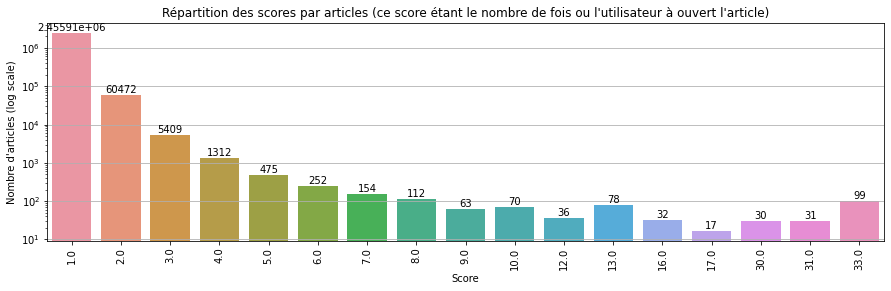

In [63]:
selection = data_score1[['session_id', 'score']].copy()
selection = pd.DataFrame(selection.groupby('score').size(), columns=['count'])

selection["count_percent"] = 100 / data_score1.shape[0] * selection
display(selection.T)
selection = selection[['count']].T

plot_bars(
    selection, 
    "Répartition des scores par articles (ce score étant le nombre de fois ou l'utilisateur à ouvert l'article)", 
    x_label="Score", y_label="Nombre d'articles (log scale)",
    labels_modulo=1, show_values=True, log_scale=True, show_grid=True, 
)

In [64]:
describe_with_extraQ(data_score1.score, [0.01, 0.97, 0.98, 0.99]).T

,count,mean,std,min,25%,50%,75%,max,1.0%,97.0%,98.0%,99.0%
score,2524552.00,1.03,0.35,1.00,1.00,1.00,1.00,33.00,1.00,1.00,2.00,2.00


> ⚠️ Vu sa répartition et sa nature *(des entiers)*, ce score ne semble pas très utile... *(plus de 97% des articles ont été visités une seule fois et ont donc un score de 1)*

### 4.3.2 Score basé sur le temps écoulé entre deux articles d'une même session
*(il faut des sessions de 2 articles mini, et le dernier sera perdu car on a pas de temps de cloture des sessions)*

#### Calculons le temps entre 2 sessions *(donc session_size-1)*, et un ratio de ce temps en fonction du nombre de mots dans l'article

In [65]:
selection = data_merge[['user_id', 'article_id', 'session_id', 'session_start', 'session_size', 'click_timestamp', 'words_count']].copy()
selection = selection.sort_values('click_timestamp')

data_score2 = selection.groupby('session_id').diff(periods=-1)
data_score2.rename(columns={'click_timestamp':'duration'}, inplace=True)
data_score2 = -data_score2['duration']/1000

data_score2 = pd.concat([selection, data_score2], axis=1)
data_score2['duration_ratio'] = data_score2['duration'] / data_score2['words_count']
display(data_score2.head(3), data_score2.shape)

,user_id,article_id,session_id,session_start,session_size,click_timestamp,words_count,duration,duration_ratio
147,59,234853,1506826329267796,1506826329000,2,1506826800026,140,30.00,0.21
208,79,159359,1506826486139816,1506826486000,2,1506826801702,139,30.00,0.22
399,154,96663,1506826793323891,1506826793000,2,1506826804207,206,30.00,0.15


(2988181, 9)

#### Regardons un exemple avec 10 clicks pour vérifier les valeurs

In [66]:
data_score2[data_score2.session_id == 1507932701183006]

,user_id,article_id,session_id,session_start,session_size,click_timestamp,words_count,duration,duration_ratio
2583358,252642,5242,1507932701183006,1507932701000,10,1508714220422,194,83334.67,429.56
2583359,252642,50427,1507932701183006,1507932701000,10,1508797555093,186,601206.26,3232.29
2583360,252642,283069,1507932701183006,1507932701000,10,1509398761350,170,24.35,0.14
2583361,252642,257890,1507932701183006,1507932701000,10,1509398785698,205,28.59,0.14
2583362,252642,198748,1507932701183006,1507932701000,10,1509398814292,182,233.89,1.29
2583363,252642,50759,1507932701183006,1507932701000,10,1509399048186,215,89574.18,416.62
2583364,252642,156073,1507932701183006,1507932701000,10,1509488622369,226,62347.90,275.88
2583365,252642,283975,1507932701183006,1507932701000,10,1509550970271,184,542912.59,2950.61
2583366,252642,207672,1507932701183006,1507932701000,10,1510093882860,242,30.00,0.12
2583367,252642,96333,1507932701183006,1507932701000,10,1510093912860,299,NaN,NaN


#### Supprimons les derniers articles de chaque session *(puisque l'on a pas leur durée)*

In [67]:
data_score2 = data_score2[data_score2.duration.notnull()]
data_score2.shape

(1939587, 9)

#### Affichons la repartition des valeurs de la colonne `duration`

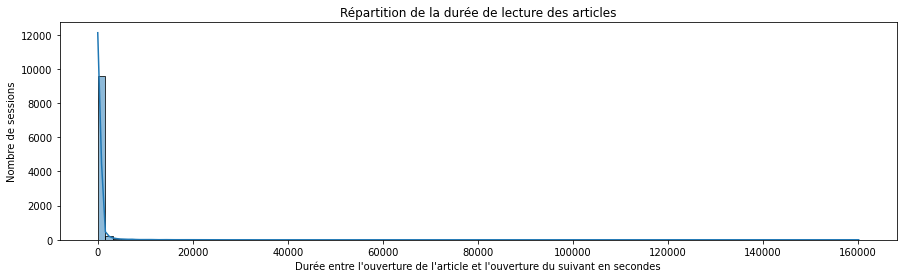

In [68]:
fig = plt.figure(figsize=(15, 4))
ax = sns.histplot(data=data_score2['duration'].dropna().sample(10000, random_state=random_seed), bins=100, kde=True, log_scale=False )
plt.title("Répartition de la durée de lecture des articles")
plt.ylabel("Nombre de sessions")
plt.xlabel("Durée entre l'ouverture de l'article et l'ouverture du suivant en secondes")
plt.show()

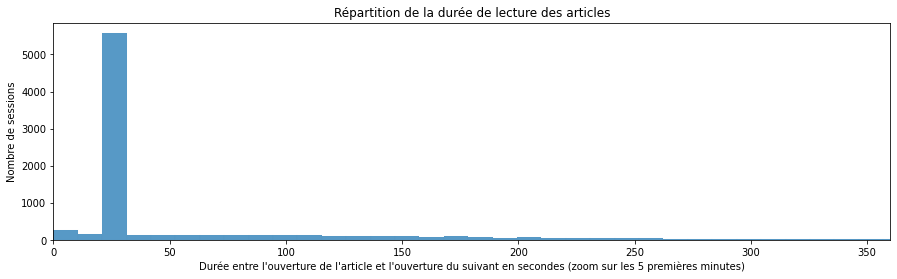

In [69]:
fig = plt.figure(figsize=(15, 4))
ax = sns.histplot(data=data_score2['duration'].dropna().sample(10000, random_state=random_seed), bins='auto', kde=False, log_scale=False )
plt.title("Répartition de la durée de lecture des articles")
plt.ylabel("Nombre de sessions")
plt.xlabel("Durée entre l'ouverture de l'article et l'ouverture du suivant en secondes (zoom sur les 5 premières minutes)")
plt.xlim([0,360])
plt.show()

In [70]:
describe_with_extraQ(data_score2.duration, [0.01, 0.97, 0.98, 0.99]).T

,count,mean,std,min,25%,50%,75%,max,1.0%,97.0%,98.0%,99.0%
duration,1939587.00,452.47,5313.35,-0.00,30.00,30.00,143.65,1212149.26,3.29,2062.44,3216.53,6596.01


#### Supprimons les outliers *(les extrêmes qui ne semblent pas raisonnables dans ce contexte)*

In [71]:
# On supprime les news dont le temps de consultation est inférieur à quartile(0.01) soit environ 3 secondes
data_score2 = data_score2[data_score2.duration > data_score2.duration.quantile(0.01)]
# On supprime les news dont le temps de consultation est supérieur à quartile(0.98) soit environ 55 minutes
data_score2 = data_score2[data_score2.duration < data_score2.duration.quantile(0.98)]

data_score2.shape

(1881785, 9)

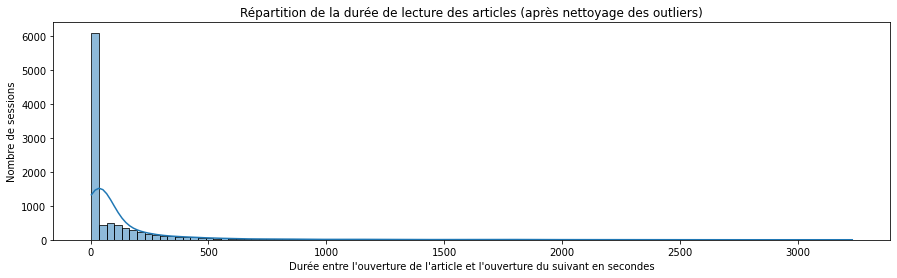

In [72]:
fig = plt.figure(figsize=(15, 4))
ax = sns.histplot(data=data_score2['duration'].dropna().sample(10000, random_state=random_seed), bins=100, kde=True, log_scale=False )
plt.title("Répartition de la durée de lecture des articles (après nettoyage des outliers)")
plt.ylabel("Nombre de sessions")
plt.xlabel("Durée entre l'ouverture de l'article et l'ouverture du suivant en secondes")
plt.show()

#### Affichons la repartition des valeurs de la colonne `duration_ratio` et de `words_count` dont elle dépend

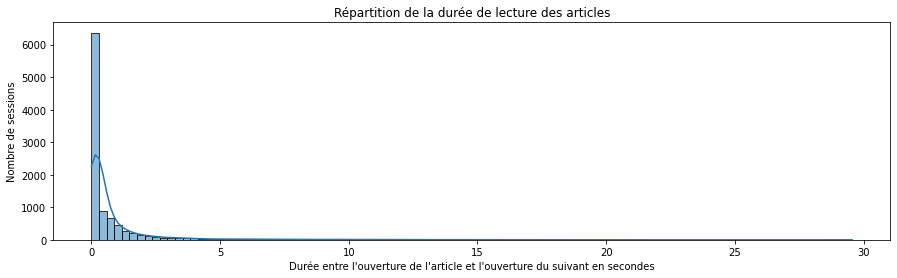

In [73]:
fig = plt.figure(figsize=(15, 4))
ax = sns.histplot(data=data_score2['duration_ratio'].dropna().sample(10000, random_state=random_seed), bins=100, kde=True, log_scale=False )
plt.title("Répartition de la durée de lecture des articles")
plt.ylabel("Nombre de sessions")
plt.xlabel("Durée entre l'ouverture de l'article et l'ouverture du suivant en secondes")
plt.show()

In [74]:
describe_with_extraQ(data_score2.duration_ratio, [0.005, 0.01, 0.99, 0.995]).T

,count,mean,std,min,25%,50%,75%,max,0.5%,1.0%,99.0%,99.5%
duration_ratio,1881785.00,inf,NaN,0.00,0.14,0.18,0.67,inf,0.02,0.03,10.96,13.57


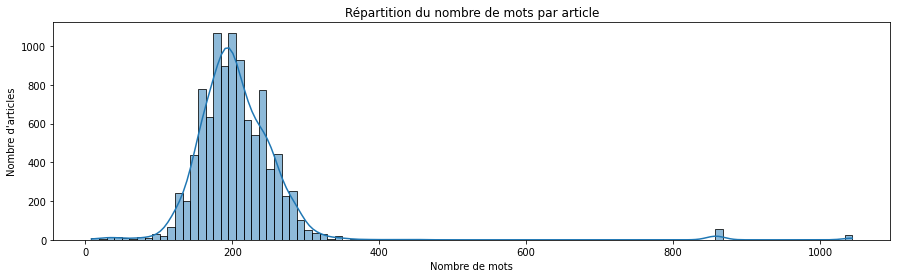

In [75]:
fig = plt.figure(figsize=(15, 4))
ax = sns.histplot(data=data_score2['words_count'].dropna().sample(10000, random_state=random_seed), bins=100, kde=True, log_scale=False )
plt.title("Répartition du nombre de mots par article")
plt.ylabel("Nombre d'articles")
plt.xlabel("Nombre de mots")
plt.show()

In [76]:
describe_with_extraQ(data_score2.words_count, [0.005, 0.01, 0.99, 0.995]).T

,count,mean,std,min,25%,50%,75%,max,0.5%,1.0%,99.0%,99.5%
words_count,1881785.00,209.10,81.74,0.00,174.00,199.00,234.00,6690.00,61.00,100.00,414.00,858.00


> #### On constate que les `duration_ratio` ont quelques valeurs infinies car on a quelques `words_count` à 0 !
> Nous allons donc faire le ménage dans les words_count en supprimant les outliers

#### Supprimons les outliers *(les extrêmes qui ne semblent pas raisonnables dans ce contexte)*

In [77]:
# On supprime les news dont le nombre de mot est inférieur à quartile(0.005) soit environ 60 mots
data_score2 = data_score2[data_score2.words_count > data_score2.words_count.quantile(0.005)]
# On supprime les news dont le nombre de mot est supérieur à quartile(0.995) soit environ 850 mots
data_score2 = data_score2[data_score2.words_count < data_score2.words_count.quantile(0.995)]

data_score2.shape

(1855641, 9)

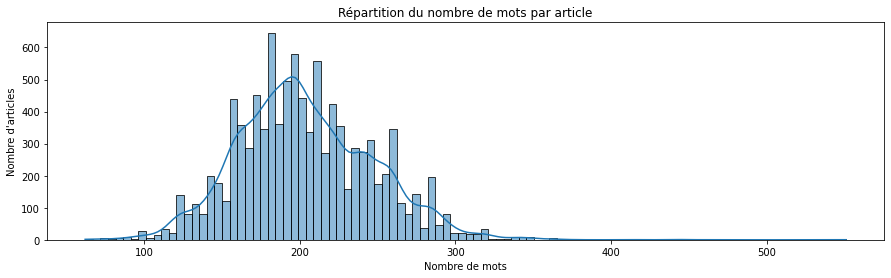

In [78]:
fig = plt.figure(figsize=(15, 4))
ax = sns.histplot(data=data_score2['words_count'].dropna().sample(10000, random_state=random_seed), bins=100, kde=True, log_scale=False )
plt.title("Répartition du nombre de mots par article")
plt.ylabel("Nombre d'articles")
plt.xlabel("Nombre de mots")
plt.show()

In [79]:
describe_with_extraQ(data_score2.words_count, [0.005, 0.01, 0.99, 0.995]).sort_index().T

,0.5%,1.0%,25%,50%,75%,99.0%,99.5%,count,max,mean,min,std
words_count,100.00,115.00,174.00,198.00,232.00,314.00,328.00,1855641.00,793.00,203.56,62.00,43.51


#### Vérifions à nouveau la répartition des `duration_ratio`

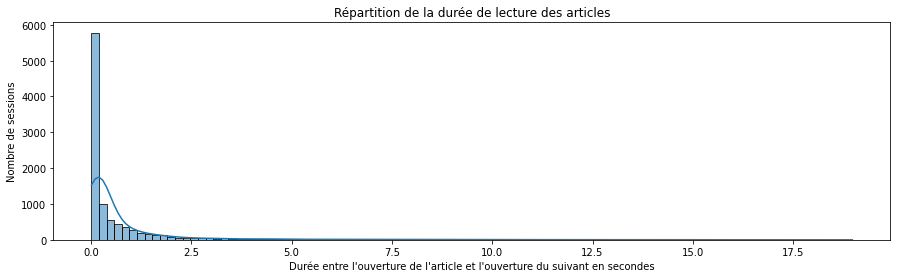

In [80]:
fig = plt.figure(figsize=(15, 4))
ax = sns.histplot(data=data_score2['duration_ratio'].dropna().sample(10000, random_state=random_seed), bins=100, kde=True, log_scale=False )
plt.title("Répartition de la durée de lecture des articles")
plt.ylabel("Nombre de sessions")
plt.xlabel("Durée entre l'ouverture de l'article et l'ouverture du suivant en secondes")
plt.show()

In [81]:
describe_with_extraQ(data_score2.duration_ratio, [0.005, 0.01, 0.99, 0.995]).sort_index().T

,0.5%,1.0%,25%,50%,75%,99.0%,99.5%,count,max,mean,min,std
duration_ratio,0.03,0.04,0.14,0.18,0.67,10.81,13.27,1855641.00,42.78,0.85,0.01,1.95


> #### Ce score semble raisonnablement exploitable.
> On a une répartition des scores qui permet de séparer les articles en plusieurs groupes.<br>
> Certains sont plus présents que d'autres, mais vont être pondérés par les algorithmes de recommandation.

## 4.5 Séparation du jeu de données en train-set & test-set <a class="anchor" id="dataset_split"></a> [⇪](#menu)

### click_timestampPréparons un jeu de données contenant les colonnes qui nous intéressent

In [82]:
data_export = data_score2[['user_id', 'article_id', 'duration_ratio', 'click_timestamp']].sort_values('click_timestamp')
data_export.rename(columns={'duration_ratio':'score'}, inplace=True)
display(data_export.head(3), data_export.shape)

,user_id,article_id,score,click_timestamp
147,59,234853,0.21,1506826800026
208,79,159359,0.22,1506826801702
399,154,96663,0.15,1506826804207


(1855641, 4)

### Trouvons à quel timestamp séparer le jeu de données *(puisque nous avons des données temporelles)*

In [83]:
describe_with_extraQ(data_export.click_timestamp, [0.85]).T

,count,mean,std,min,25%,50%,75%,max,85.0%
click_timestamp,1855641.00,1507478821746.30,382308832.56,1506826800026.00,1507133166733.00,1507501200168.00,1507750971199.00,1510603424886.00,1507916395989.00


> #### Il semble raisonnable de faire une séparation à 85% de la timeline

### Séparons le jeu de données en deux sets

In [84]:
separation_threshold = 0.85
data_train = data_export[data_export.click_timestamp <= data_export.click_timestamp.quantile(separation_threshold)]
data_valid = data_export[data_export.click_timestamp > data_export.click_timestamp.quantile(separation_threshold)]
print(f"Train-set:{data_train.shape} | Valid-set:{data_valid.shape}")

Train-set:(1577295, 4) | Valid-set:(278346, 4)


> #### La quantité de lignes dans chaque dataset semble raisonnable pour de l'apprentissage et de l'évalution

### Regardons la quantité d'utilisateurs présents dans les deux jeux de données *(pour pouvoir faire une évaluation)*

In [85]:
data_train_users_id = set(data_train.user_id)
data_valid_users_id = set(data_valid.user_id)
print(f"Nombre d'utilisateurs dans le Train-set: {data_train.user_id.nunique()} \nNombre d'utilisateurs dans le Valid-set: {data_valid.user_id.nunique()} \nNombre d'utilisateurs communs: {len(data_train_users_id.intersection(data_valid_users_id))}")

Nombre d'utilisateurs dans le Train-set: 297141 
Nombre d'utilisateurs dans le Valid-set: 107549 
Nombre d'utilisateurs communs: 84041


### Supprimons du jeu de données `data_valid` les entrées liées aux utilisateurs qui ne sont pas dans les deux jeux de données

In [86]:
data_valid = data_valid[ data_valid.user_id.isin(data_train_users_id) ]
print(f"Le Valid-set contient {data_valid.shape[0]} entrées pour {data_valid.user_id.nunique()} utilisateurs uniques (qui sont également présents dans le Train-set) et {data_valid.article_id.nunique()} articles uniques")

Le Valid-set contient 241105 entrées pour 84041 utilisateurs uniques (qui sont également présents dans le Train-set) et 7576 articles uniques


### Normalisons les scores

In [87]:
data_train['score'] = (data_train['score'] - data_train['score'].mean())/data_train['score'].std()
data_valid['score'] = (data_valid['score'] - data_valid['score'].mean())/data_valid['score'].std()

### Exportons les deux jeux de données

In [88]:
data_train.drop('click_timestamp', axis=1, inplace=True)
data_valid.drop('click_timestamp', axis=1, inplace=True)

In [89]:
data_train.to_csv('data/data_train.csv', index=False)
data_valid.to_csv('data/data_valid.csv', index=False)

In [90]:
check_train = pd.read_csv('data/data_train.csv')
check_train.head(3)

,user_id,article_id,score
0,59,234853,-0.33
1,79,159359,-0.33
2,154,96663,-0.36


In [91]:
check_valid = pd.read_csv('data/data_valid.csv')
check_valid.head(3)

,user_id,article_id,score
0,279777,96210,-0.39
1,29634,284773,-0.21
2,55,162605,0.21


## Test de chargement des Embeddings pour la suite du projet

articles_embeddings.pickle Pickle (Python 3) of a NumPy matrix containing the Article Content Embeddings (250-dimensional vectors), trained upon articles' text and metadata by the CHAMELEON's ACR module (see paper for details) for 364047 published articles.
P.s. The full text of news articles could not be provided due to license restrictions, but those embeddings can be used by Neural Networks to represent their content. See this paper for a t-SNE visualization of these embeddings, colored by category.

In [92]:
file = open('data/news-portal-user-interactions-by-globocom/articles_embeddings.pickle',"rb")
article_embedding = pickle.load(file)

In [93]:
article_embedding

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [94]:
article_embedding.shape

(364047, 250)

In [95]:
article_embedding[96210]

array([-0.63533664, -0.97343034, -0.2746781 , -0.51361626, -0.4744826 ,
        0.7951861 , -0.17472684,  0.12588805, -0.91681516, -0.05771385,
        0.697845  , -0.7214228 , -0.53106874,  0.5508195 ,  0.8791882 ,
        0.23318997,  0.23100792,  0.47722673,  0.1548369 , -0.05020399,
        0.67901015, -0.8266115 , -0.66494507, -0.8747525 ,  0.53258467,
        0.72484696, -0.18544452, -0.03293263,  0.87412786, -0.2792242 ,
        0.3867818 ,  0.8085285 , -0.8004489 ,  0.7200558 , -0.0620467 ,
        0.04345929,  0.8480556 ,  0.3135612 , -0.26583555,  0.56032604,
        0.48959953, -0.26810884, -0.30767342, -0.96265733,  0.70179164,
        0.6291721 , -0.35248786, -0.0758154 , -0.78297514,  0.37906784,
        0.3297576 , -0.5501892 ,  0.59629434,  0.88500744, -0.7311726 ,
        0.49164367,  0.7416593 ,  0.8069588 ,  0.94806993,  0.3389954 ,
        0.89122635, -0.44240233,  0.66122615,  0.71594787,  0.34924483,
        0.53780055,  0.40463766,  0.66839415, -0.3180253 ,  0.87